**<h2 style = "BentonSans-Light,helvetica,sans-serif; color: #2196f3"> Code Submission by Team Thunder_BUDDIES </h2>**

                                                                                - Siva Sankar S
                                                                                - Tejashaarav S
                                                                                - Keerthy Babu D
                                                                                
This is notebook is a compilation of all the approaches tried by our team. 


|Name|College|Course|Batch Year|Roll no.|Mobile Numer|Email-ID|
|---|---|---|---|---|---|---|
|Siva Sankar S| IIT-Madras|B.Tech in Chemical Engineering|2024|CH20B103|9283217898|ch20b103@smail.iitm.ac.in|
|Keerthy Babu D|	IIT Madras	|B.Tech in Chemical Engineering	|2024	|CH20B059	|7483013164	|ch20b059@smail.iitm.ac.in|
|Tejashaarav S|	IIT Madras	|B.Tech in Chemical Engineering	|2024	|CH20B107	|9080783016	|ch20b107@smail.iitm.ac.in|


## Imports <a class="anchor" id="first-bullet"></a>


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import torch
import pytorch_lightning as pl
import torch.nn as nn
import math
import random

import warnings

from IPython.display import clear_output

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim

from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint 

from sklearn.impute import *
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from autogluon.tabular import TabularDataset, TabularPredictor
from pytorch_tabnet.tab_model import TabNetClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

clear_output()
np.random.seed(42) 

## Data Processing and analysis <a class = "anchor" id ="dpa"></a>

In [2]:
df_X = pd.read_csv('Modelling_Students/train_allx.csv')
df_y = pd.read_csv('Modelling_Students/train_y.csv')
df_val = pd.read_csv('Modelling_Students/val_allx.csv')

### Reshuffling the data to remove any bias in the original data

In [3]:
# Shuffle
df_X = df_X.sample(frac=1.)
df_y = df_y.reindex(df_X.index)

## Basic Analysis

### Heavy class imbalance:
* The data is highly skewed with label 0 being the majority class (74.11 %) and label 1 being minority class (7.52 %).
* To overcome this class imbalance problem, we tried to use SMOTE algorithm to artificially generate data points.
* We also tried under-sampling majority class and over-sampling the minority classes.
* Handling the imbalance in given data doesnt necessarily improve the accuracy of our predictions which is the major scoring metric for this competition
* We observed that changing the original distribution improved F1 scores but overall accuracy is also reduced.

In [26]:
n = len(df_y)
for (label,),count in df_y.value_counts().sort_index().items():
    print(f'Total count of Default Flag label {label}:\t {count}\t ({round(count/n*100,2)}%)')

Total count of Default Flag label 0:	 340085	 (74.11%)
Total count of Default Flag label 1:	 34501	 (7.52%)
Total count of Default Flag label 2:	 46424	 (10.12%)
Total count of Default Flag label 3:	 37903	 (8.26%)


<AxesSubplot: ylabel='Count'>

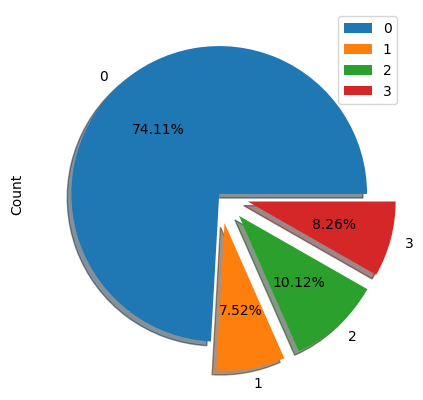

In [28]:
df_y.value_counts().sort_index().reset_index(name='Count').plot(kind='pie',x='Default_Flag',y='Count',
                                                            explode=[0,0.2,0.2,0.2],autopct=lambda p:f'{p:.2f}%',
                                                            shadow=True)

# Large number of NaNs

In [14]:
print('NaN counts')
for col_name,nan_count in df_X.isna().sum().sort_values(ascending=False).items():
    if nan_count:
        print(f'Column Name: {col_name} \t-------\t Count: {nan_count}\t-------\t Percentage: {round(nan_count/n*100,2)} %')

NaN counts
Column Name: D_17 	-------	 Count: 458268	-------	 Percentage: 99.86 %
Column Name: D_38 	-------	 Count: 458086	-------	 Percentage: 99.82 %
Column Name: D_43 	-------	 Count: 456286	-------	 Percentage: 99.43 %
Column Name: D_39 	-------	 Count: 455235	-------	 Percentage: 99.2 %
Column Name: D_96 	-------	 Count: 455235	-------	 Percentage: 99.2 %
Column Name: B_7 	-------	 Count: 454808	-------	 Percentage: 99.11 %
Column Name: D_73 	-------	 Count: 454674	-------	 Percentage: 99.08 %
Column Name: B_22 	-------	 Count: 452771	-------	 Percentage: 98.66 %
Column Name: D_114 	-------	 Count: 442518	-------	 Percentage: 96.43 %
Column Name: D_132 	-------	 Count: 442518	-------	 Percentage: 96.43 %
Column Name: D_12 	-------	 Count: 442518	-------	 Percentage: 96.43 %
Column Name: D_80 	-------	 Count: 442518	-------	 Percentage: 96.43 %
Column Name: D_97 	-------	 Count: 442518	-------	 Percentage: 96.43 %
Column Name: R_8 	-------	 Count: 431960	-------	 Percentage: 94.13

### Handling the NaNs
* In order to find optimal approach to handling NaNs, we tried out various strategies and compared the accuracies we got with a cross validated control model
* We also discovered that Histogram-based Gradient Boosting Classification Tree is robust with NaNs. Sklearn implementation of the algorithm have native support for handling NaNs.
> "During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain" -  Sklearn Documentaion on Histogram-based Gradient Boosting Classification Tree

In [5]:

clf = HistGradientBoostingClassifier()
X = pd.get_dummies(df_X)
score = cross_val_score(clf,X,df_y.iloc[:,0],n_jobs=3)
print(f'Mean cross validated score for Histogram based gradient boosting classification tree:\t {score.mean()}')

Mean cross validated score for Histogram based gradient boosting classification tree:	 0.8146184532085133


* Some strategies we tried out and tested are:
    * Mean Imputation with and without NaN indicator
    * Median Imputation with and without NaN indicator
    * KNN based imputation with and without NaN indicator
    * Constant fill with and without NaN indicator

* We observed that most frequent fill without NaN indicator and constant fill with value: 0 is the most optimal upon testing on multiple models.

In [ ]:
def sample(n=5000):
    """
    Returns random samples from the main data. Used for experiments on the data
    """
    X = pd.get_dummies(df_X) 
    Samples_X = X.sample(5000)
    Samples_y = df_y.loc[Samples_X.index]
    return Samples_X,Samples_y

In [ ]:

strategies = ['mean','median','most_frequent','constant']

Samples_X,Samples_y = sample()

clf = HistGradientBoostingClassifier() # HistGradientBoostingClassifier is used as reference model
score = cross_val_score(clf,Samples_X,Samples_y.iloc[:,0],n_jobs=3,cv=3)    
print(f'Mean cross validated score without handling NaN:\t {score.mean()}\n')

for strategy in strategies:
    imputator = SimpleImputer(strategy=strategy,add_indicator=False).fit(X) # No NaN indicator
    Samples_X_testing = imputator.transform(Samples_X)
    clf = HistGradientBoostingClassifier() 
    score = cross_val_score(clf,Samples_X_testing,Samples_y.iloc[:,0],n_jobs=3,cv=3) 
    print(f'Mean cross validated score for {strategy} without NaN indicator:\t {score.mean()}') 

    imputator = SimpleImputer(strategy=strategy,add_indicator=True).fit(Samples_X) # With NaN indicator
    Samples_X_testing = imputator.transform(Samples_X)
    clf = HistGradientBoostingClassifier() 
    score = cross_val_score(clf,Samples_X_testing,Samples_y.iloc[:,0],n_jobs=3,cv=3) 
    print(f'Mean cross validated score for {strategy} with NaN indicator:\t {score.mean()}\n\n')

Mean cross validated score without handling NaN:	 0.7987997838607549

Mean cross validated score for mean without NaN indicator:	 0.802200064188843
Mean cross validated score for mean with NaN indicator:	 0.8033999442608476


Mean cross validated score for median without NaN indicator:	 0.8030005043409085
Mean cross validated score for median with NaN indicator:	 0.8036012245330045


Mean cross validated score for most_frequent without NaN indicator:	 0.806200464588955
Mean cross validated score for most_frequent with NaN indicator:	 0.8032013045170078


Mean cross validated score for constant without NaN indicator:	 0.8053991842687885
Mean cross validated score for constant with NaN indicator:	 0.8049994243648269




### Does dropping features with high count of NaN's improve score?
* We tried dropping features that have a high count of NaN values and we did observe that it didn't improve the accuracy of the predictions.

In [ ]:
cutoff = 0.9
Samples_X,Samples_y = sample()
to_drop = (Samples_X.isna().sum().sort_values(ascending=False)/len(Samples_X)>cutoff)
to_drop_cols = to_drop.loc[to_drop].index
print(f'Total of {len(to_drop_cols)} columns to be dropped.')
Samples_X_testing = Samples_X.drop(to_drop_cols,axis=1)

Total of 15 columns to be dropped.


In [ ]:
Samples_X_testing = SimpleImputer(strategy='most_frequent',add_indicator=False).fit_transform(Samples_X_testing) 
Samples_X = SimpleImputer(strategy='most_frequent',add_indicator=False).fit_transform(Samples_X) 
clf = HistGradientBoostingClassifier() 
score_testing = cross_val_score(clf,Samples_X_testing,Samples_y.iloc[:,0],n_jobs=3,cv=3) 
score_control = cross_val_score(clf,Samples_X,Samples_y.iloc[:,0],n_jobs=3,cv=3) 
print(f'Mean cross validated score without frequent NaN features dropped:\t {score_control.mean()}\n\n')
print(f'Mean cross validated score with frequent NaN features dropped:\t {score_testing.mean()}\n\n')

Mean cross validated score without frequent NaN features dropped:	 0.8042000243408701


Mean cross validated score with frequent NaN features dropped:	 0.8037992641567726




# Scaling the data
* For tree based models, scaling the data makes no difference as they are not sensitive to variance in the data.
* Scaling the data makes learning easier for models that uses gradient descends.
* Based on our experiments, quantile transformer with linear distribution worked the best

In [ ]:

tree_based_model = DecisionTreeClassifier
gradient_based_model = MLPClassifier

scalers = [('Standard Scaler',StandardScaler()),('Robust Scaler',RobustScaler()),('Quantile Transformer Uniform',QuantileTransformer()),('Quantile Transformer Gaussian',QuantileTransformer(output_distribution='normal'))]

Samples_X, Samples_y = sample(10000)
Samples_X = SimpleImputer(strategy='most_frequent').fit_transform(Samples_X)

# Without any scaling
tree_score = cross_val_score(tree_based_model(),Samples_X,Samples_y.iloc[:,0],n_jobs=3,cv=10).mean()
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    grad_score = cross_val_score(gradient_based_model(),Samples_X,Samples_y.iloc[:,0],n_jobs=3,cv=10).mean()
print(f'Score without scaling (Tree based):\t {tree_score}')
print(f'Score without scaling (Gradient based):\t {grad_score}\n\n')

# Testing the Scalers:
for name,scaler in  scalers:
    Samples_X_testing = scaler.fit_transform(Samples_X)
    tree_score = cross_val_score(tree_based_model(),Samples_X_testing,Samples_y.iloc[:,0],n_jobs=3,cv=10).mean()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        grad_score = cross_val_score(gradient_based_model(),Samples_X,Samples_y.iloc[:,0],n_jobs=3,cv=10).mean()
    print(f'Score with {name} scaling (Tree based):\t {tree_score}')
    print(f'Score with {name} scaling (Gradient based):\t {grad_score}\n\n')


Score without scaling (Tree based):	 0.7484000000000001
Score without scaling (Gradient based):	 0.5508


Score with Standard Scaler scaling (Tree based):	 0.7448
Score with Standard Scaler scaling (Gradient based):	 0.618


Score with Robust Scaler scaling (Tree based):	 0.7434
Score with Robust Scaler scaling (Gradient based):	 0.6178


Score with Quantile Transformer Uniform scaling (Tree based):	 0.7449999999999999
Score with Quantile Transformer Uniform scaling (Gradient based):	 0.6836


Score with Quantile Transformer Gaussian scaling (Tree based):	 0.7409999999999999
Score with Quantile Transformer Gaussian scaling (Gradient based):	 0.6178




### Final set of preprocessing:
After experimenting with a lot of preprocessing methods this is the flow we have chosen for the final set of preprocessing.
* Simple Imputation with most frequent value
* Quantile Transformer to uniform distribution
* One hot encoding the categorical variables

In [6]:
class Preprocess():
    def __init__(self):
        self.imputer = SimpleImputer(strategy='most_frequent',add_indicator=False)
        self.scaler = QuantileTransformer()
        self.CatCols = None
        self.Cols = None
        
    def fit(self,df):
        self.CatCols = df.select_dtypes(exclude=['float','int']).columns
        df = pd.get_dummies(df,columns=self.CatCols,prefix='ohe')
        self.Cols = df.columns
        df = self.imputer.fit_transform(df)
        self.scaler.fit(df)
        return self

    def transform(self,df):
            df = pd.get_dummies(df,columns=self.CatCols,prefix='ohe')
            df= self.imputer.transform(df)
            df = self.scaler.transform(df)
            df = pd.DataFrame(df,columns=self.Cols)
            cats = df.columns[df.columns.str.startswith('ohe_')]
            for cat in cats: df.loc[:,cat] = df.loc[:,cat].astype(int) 
            return df

    def fit_transform(self,df):
        self.fit(df)
        return self.transform(df)
    def __call__(self,df):
         return self.transform(df)


# Attempt on feature extraction using unsupervised denoising auto-encoder
* We were hunting for a suitable auto-encoder for this dataset and we got to know about unsupervised auto-encoder
* The core idea behind this auto-encoder is to add noise to tabular data and build a model to predict the original data.
* The layer wise outputs of the model are concatenated to form new feature set for a second model.
* The main advantage of this approach is that, in the representation learning no labels are required. This means we can use both labelled train data as well as unlabelled val data.
References:
* https://www.kaggle.com/code/springmanndaniel/1st-place-turn-your-data-into-daeta/report
* https://www.kaggle.com/c/tabular-playground-series-jan-2021/discussion/216037


|![DAEs](https://s10.gifyu.com/images/deepstack_input_output_color.png)|
|:--:|
| *Denoising AutoEncoder used by Danzel, Winning solution, Tabular Playground series*|


In [7]:
# Preparing data
preprocess = Preprocess()
X = preprocess.fit_transform(df_X)
X_val = preprocess.transform(df_val)

# Sampling seperate data to test the trained data representation
df = pd.concat([pd.DataFrame(X),df_y],axis=1)
clf_data = pd.concat([G.sample(3000) for n,G in df.groupby('Default_Flag')],axis=0).sample(frac=1.)
X_clf = clf_data.drop('Default_Flag',axis=1)
y_clf = clf_data['Default_Flag']
X_repr_lr = np.concatenate([X,X_val])

In [ ]:
# Setting up pytorch dataloaders
class DataSet(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

n = int(len(df_X)*0.9)
X_train = X_repr_lr[:n]
X_test = X_repr_lr[n:]
train_data = DataSet(X_train)
test_data = DataSet(X_test)
clf_dataset = DataSet(X_clf.values)

train_dataloader = DataLoader(train_data, batch_size=1024, shuffle=True,num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=1024,num_workers=1,shuffle=True)
clf_dataloader = DataLoader(clf_dataset, batch_size=1024,num_workers=1)

In [ ]:
def eval_features(X,y):
    """
    Used to evaluate the feature quality. GaussianNB is used because of its fast training time
    """
    return cross_val_score(GaussianNB(),X,y).mean()

In [ ]:

class Representation_Learner(pl.LightningModule):
    def __init__(self,sigmas = [0.1,0.5,0.7,0.9,0.1],
                        dev='cuda',min_swaps_frac=0.1, 
                            max_swaps_frac=0.4,max_noise_frac=0.1):
        super().__init__()
        self.sigmas = sigmas
        self.min_swaps_frac = min_swaps_frac
        self.max_swaps_frac = max_swaps_frac
        self.max_noise_frac = max_noise_frac
        self.dev = dev
        self.L1 = nn.Linear(215,256) 
        self.L2 = nn.Linear(256,256)
        self.L3 = nn.Linear(256,256)
        self.L4 = nn.Linear(256,215)
        self.lrelu = nn.LeakyReLU(0.1)
    
    def forward(self,x):
        x = x.float()
        f1 = self.lrelu(self.L1(x))
        f2 = self.lrelu(self.L2(f1))
        f3 = self.lrelu(self.L3(f2))
        x = self.lrelu(self.L4(f3))
        return x,torch.concat([f1,f2,f3],dim=-1)
    
    def random_noise_feature(self,x,clone=False):
        """
        Select random number of features and add noise feature wise
        """
        if clone:
            x = torch.clone(x)
        sigma = random.choice(self.sigmas)
        p = random.randint(0,int(x.shape[1]*self.max_noise_frac)) # Number of features to add noise
        feats = torch.randint(0,x.shape[1]-1,(p,))
        noise = torch.rand((x.shape[0],p),device=self.dev) * sigma
        x[:,feats] += noise
        return x
    
    def random_noise(self,z,clone=False):
        """
        Select random entries and add noise
        """
        if clone:
            z = torch.clone(z)
        sigma = random.choice(self.sigmas)
        n = random.randint(0,int(z.numel() * self.max_noise_frac))
        nr = torch.randint(0,z.shape[0]-1,(n,))
        nf = torch.randint(0,z.shape[1]-1,(n,)) # Number of features to add noise
        c = torch.stack([nr,nf])
        noise = torch.rand((n,),device=self.dev) * sigma
        z[c[0],c[1]]  +=  noise
        return z
    
    def random_swap(self,z):
        """
        Select random elements from table and swap them
        """
        s = z.numel()
        n = random.randint(int(s* self.min_swaps_frac),int(s* self.max_swaps_frac)) # number of swaps

        nr1 = torch.randint(0,z.shape[0]-1,(n,))
        nf1 = torch.randint(0,z.shape[1]-1,(n,)) 
        c1 = torch.stack([nr1,nf1])


        nr2 = torch.randint(0,z.shape[0]-1,(n,))
        nf2 = torch.randint(0,z.shape[1]-1,(n,)) 
        c2 = torch.stack([nr2,nf2])

        z[c1[0],c1[1]], z[c2[0],c2[1]] = z[c2[0],c2[1]], z[c1[0],c1[1]]
        return z
    
    def corrupt(self,x):
        x = self.random_noise_feature(x) 
        x = self.random_noise(x)
        x = self.random_swap(x)
        return x

    
    def training_step(self,x, batch_idx):
        x = x.float()
        y = torch.clone(x) # y is original data, x is corrupted data
        x = self.corrupt(x)
        yhat = self.forward(x)[0]
        var = torch.var(x-y) # Variance of added corruption
        self.log('train_var',var)
        loss = torch.nn.functional.mse_loss(yhat,y)
        self.log('train_mse',loss)
        return loss
    
    def validation_step(self,x, batch_idx):
        x = x.float()
        y = torch.clone(x) # y is original data, x is corrupted data
        x = self.corrupt(x)
        yhat = self.forward(x)[0]
        var = torch.var(x-y) # Variance of added corruption
        self.log('val_var',var)
        loss = torch.nn.functional.mse_loss(yhat,y)
        self.log('val_mse',loss)
        return loss
    
    def validation_epoch_end(self, outputs):
        """
        Evaluate the features
        """
        with torch.no_grad():
            X_trans = [self.forward(x.to('cuda'))[1].cpu() for x in clf_dataloader]
        X_trans = torch.concat(X_trans).numpy()
        score = eval_features(X_trans,y_clf)
        self.log('val_acc',score)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-6,weight_decay=1e-4) # highly regularized
        return optimizer

In [ ]:
repr_learner = Representation_Learner()
print(f'Model score with original set of features: {eval_features(X_clf,y_clf)}')

logger = WandbLogger(name='DeepStackv2',project='Amex')
logger.watch(repr_learner)

checkpoint = ModelCheckpoint(save_top_k=3,monitor='val_mse',mode='min',dirpath='Models',filename='DeepStack_Model-{epoch:04d}-{val_mse:.10f}-{val_acc:.5f}')
trainer = pl.Trainer(max_epochs=20000,accelerator='gpu',limit_train_batches=8000,limit_val_batches=1500,logger=logger,callbacks=[checkpoint],enable_progress_bar = False)

trainer.fit(model=repr_learner, train_dataloaders=train_dataloader,val_dataloaders=test_dataloader)

| [![Screenshot-2022-10-22-at-10-18-47-AM.png](https://i.postimg.cc/fTN6kxHR/Screenshot-2022-10-22-at-10-18-47-AM.png)](https://postimg.cc/SjgZvzFB) |
| :--: |
| *Despite high hopes, the validation accuracy didnt improve. We believe the main reason for this lowered accuracy is the presence of too much NaNs. The dataset's increased dimension could be another factor. We also faced practical issue of fitting the transformed features in the memory!*|

# Filling of NaNs using own implementation of Denoising Diffusion Probabilistic Models (DDPMs)
* In recent times, Denoising Diffusion Probabilistic Models have shown some stunning performance in image generation.
* Modern image generation models like DALL-E, Stable Diffusion uses DDPMs for state of the art image generation.
* We implemented 1D version of DDPMs, DDPMs can be used to remove noise in the data as well as generate literally infinite number of data.

In [3]:
def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [4]:
class EPS_Model(pl.LightningModule):
    def __init__(self,timesteps=250,dev='cuda'):
        super().__init__()
        self.default_t = timesteps-1
        self.dev = dev
        self.timesteps = timesteps
        self.embeddings = torch.nn.Embedding(timesteps,16)
        self.B1 = nn.BatchNorm1d(16)
        self.B2 = nn.BatchNorm1d(1)
        self.C1 = nn.Conv1d(1,16,5,padding='same')
        self.C2 = nn.Conv1d(16,16,5,padding='same')
        self.C3 = nn.Conv1d(16,1,5,padding='same')
        self.M1 = nn.MaxPool1d(2,2)
        self.L1 = nn.Linear(215+8,512) 
        self.L2 = nn.Linear(512,256)
        self.L3 = nn.Linear(256,64)
        self.L4 = nn.Linear(64,256)
        self.L5 = nn.Linear(256,215)
    
    def forward(self,x,t=None):
        if t is None:
            t = torch.ones((x.shape[0],), device=self.dev, dtype=torch.long) * self.default_t
        embeds = self.embeddings(t)
        e = self.B1(embeds).reshape(embeds.shape[0],1,-1)
        e1 = self.C1(e)
        e2 = self.C2(e1) + e1
        e3 = self.C3(e2) 
        e4 = self.M1(e3)  
        e4 = self.B2(e4)
        x = torch.cat([x,e4.squeeze()],-1).float()
        x = torch.relu(self.L1(x))
        x = torch.relu(self.L2(x))
        f = torch.relu(self.L3(x))
        x = torch.relu(self.L4(f))
        x = torch.sigmoid(self.L5(x))
        return x,f
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self.forward(batch)[1]

In [8]:


class DiffusionModel(pl.LightningModule):
    def __init__(self,timesteps,eps_model,loss=None,dev='cuda') -> None:
        super().__init__()
        self.timesteps = timesteps
        self.dev = dev
        self.default_t = timesteps-1

        self.beta = cosine_beta_schedule(timesteps).to(dev)
        self.alpha = 1 - self.beta
        self.alpha_bar = self.alpha.cumprod(-1)
        self.a = self.alpha_bar**0.5 
        self.b = (1-self.alpha_bar)**0.5
        self.alphas_bar_prev = nn.functional.pad(self.alpha_bar[:-1], (1, 0), value=1.0)
        self.post_var  = self.beta * (1. - self.alphas_bar_prev) / (1. - self.alpha_bar)

        self.eps_model = eps_model.to(dev)
        if dev=='cuda':
            self.predictor = pl.Trainer(accelerator='gpu')
        else:
            self.predictor = pl.Trainer(accelerator='cpu')
        if loss:
            self.loss_fn = loss
        else:
            self.loss_fn = nn.functional.mse_loss
    
    def forward(self,xt,t):
        return self.eps_model(xt,t)[0]

    def q_sample(self,x0,t,noise=None):
        # adds noise, xt -> xt+1
        if noise is None:
            noise = torch.rand_like(x0).to(self.dev)
        if torch.is_tensor(t):
            t = t.long()
        return self.a[t].reshape(-1,1) * x0 + self.b[t].reshape(-1,1) * noise

    def p_sample(self,xt,t):
        # remove noise, xt -> xt-1
        eps = self.forward(xt,t)
        a = 1/self.alpha[t].reshape(-1,1)**0.5 * (xt - self.beta[t].reshape(-1,1)*eps/(1-self.alpha_bar[t].reshape(-1,1)**0.5))
        b = self.beta[t].reshape(-1,1)
        return a + eps*b
    
    def sample(self,noise=None,steps=None):
        if noise is None:
            noise = torch.rand_like(self.shape)
        if steps is None:
            steps = self.timesteps
        x = noise
        for t_bar in range(steps):
            x = self.p_sample(x,self.timesteps-t_bar)
        return x
        
    def training_step(self,x0, batch_idx):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.timesteps, (batch_size,), device=x0.device, dtype=torch.long)
        eps = torch.rand_like(x0)
        xt = self.q_sample(x0,t)
        eps_pred = self.p_sample(xt,t)
        loss = self.loss_fn(eps_pred,eps)
        self.log('train_mse',loss)
        return loss
    
    def validation_step(self,x0, batch_idx):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.timesteps, (batch_size,), device=x0.device, dtype=torch.long)
        eps = torch.rand_like(x0)
        xt = self.q_sample(x0,t)
        eps_pred = self.p_sample(xt,t)
        loss = self.loss_fn(eps_pred,eps)
        self.log('val_mse',loss)
        return loss
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-6,weight_decay=1e-12)
        return optimizer

In [9]:
timesteps = 250
eps_model = EPS_Model(timesteps,dev='cpu')
diffusion_model = DiffusionModel(timesteps,eps_model,dev='cpu')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
logger = WandbLogger(name='Diffusion',project='Amex')
logger.watch(diffusion_model)

In [ ]:
checkpoint = ModelCheckpoint(save_top_k=3,monitor='val_mse',mode='min',dirpath='Models',filename='Diffusion-Model-{epoch:04d}-{val_mse:.10f}-{val_acc:.5f}')
trainer = pl.Trainer(max_epochs=20000,logger=logger,callbacks=[checkpoint],accelerator='gpu',limit_train_batches=5000,limit_val_batches=1500,resume_from_checkpoint='Models/Diffusion-Model-epoch=3003-val_mse=0.9410688280-val_acc=0.49567.ckpt')
trainer.fit(model=diffusion_model, train_dataloaders=train_dataloader,val_dataloaders=test_dataloader)

| [![Screenshot-2022-10-22-at-10-34-45-AM.png](https://i.postimg.cc/qqV2Xcqm/Screenshot-2022-10-22-at-10-34-45-AM.png)](https://postimg.cc/0Mn69wpm) |
| :---: |
| *The validation error even after about 4000 epochs was too high. It might have converged if given more training time. Due to time constraints we stopped it to explore other things. Nevertheless we had fun working on it!*|

# Trying out different models

In [9]:
preprocess = Preprocess().fit(df_X)
X = preprocess.transform(df_X)
y = df_y.iloc[:,0]

### Machine Learning Models
* We tried different tree based classifier models and the performances were almost the same.

In [11]:
clf = RandomForestClassifier(n_estimators=200)
print(f'Random Forest Classifier: \t {cross_val_score(clf,X,y,n_jobs=3,cv=3).mean()}')

clf = GradientBoostingClassifier(n_estimators=200)
print(f'Gradient Boosting Classifier: \t {cross_val_score(clf,X,y,n_jobs=3,cv=3).mean()}')

clf = HistGradientBoostingClassifier()
print(f'Histogram based Gradient Boosting Classifier: \t {cross_val_score(clf,X,y,n_jobs=3,cv=3).mean()}')

clf = ExtraTreesClassifier(n_estimators=200)
print(f'Extra Trees Classifier: \t {cross_val_score(clf,X,y,n_jobs=3,cv=3).mean()}')

Random Forest Classifier: 	 0.8101797072647757
Gradient Boosting Classifier: 	 0.8154879029358506
Histogram based Gradient Boosting Classifier: 	 0.8142698071311991
Extra Trees Classifier: 	 0.8057758224325743


### XGBoost
* XGBoost (Extreme Gradient boosting) is a highly efficient, regularised implementation of Gradient Boosted Trees.

> XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable - Official Documentation


References:
* https://xgboost.readthedocs.io/en/stable/
* https://www.geeksforgeeks.org/xgboost/
* https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


|![DAEs](https://s1.gifyu.com/images/image4368fb1ff45e09af.png)|
|:--:|
| *Flowchart of XGBoost,Degradation state recognition of piston pump based on ICEEMDAN and XGBoost by Rui Guo*|

In [12]:
clf = XGBClassifier() # Default parameters
sc = cross_val_score(clf,X,y,n_jobs=3,cv=3).mean()
clear_output()
print(f'Xgboost Classifier: \t {sc}')

Xgboost Classifier: 	 0.8147557380157023


### Light GBM Model
* LGBM is a gradient boosting model that uses decision trees to increases the efficiency of the model and reduces memory usage. 
* The Model uses gradient-based one side sampling and exclusive feature bundling (EFB) in order to address the constraints of histogram-based approach  which is largely employed in all GBDT models.
* In contrast to previous boosting algorithms that develop trees level-by-level, LightGBM divides the tree leaf-wise. It selects the leaf with the greatest delta loss for growth.
* The leaf-wise algorithm has less loss than the level-wise algorithm since the leaf is fixed.
* The complexity of the model could rise as a result of leaf-wise tree growth, which could also result in overfitting in limited samples.

References:
* https://lightgbm.readthedocs.io/en/v3.3.2/
* https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/
* https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc


|![DAEs](https://s1.gifyu.com/images/imagecdb5e6b33277ba69.png)|
|:--:|
| *How Light GBM Models work, What is LightGBM, How to implement it? How to fine tune the parameters? by Pushkar Mandot*|



In [13]:
clf = LGBMClassifier() # Default parameters
sc = cross_val_score(clf,X,y,n_jobs=3,cv=3).mean() # Fastest fit at 2.5 seconds per model!
clear_output()
print(f'LGBM Classifier: \t {sc}') 

LGBM Classifier: 	 0.8154813657490635


### Cat Boost Classifier

* CatBoost is a high-performance open source library for gradient boosting on decision trees. 
* It produces cutting-edge results without the substantial data training that other machine learning techniques normally demand, and it offers strong out-of-the-box support for the more descriptive data formats that go along with many commercial problems.
* In order to limit the number of features split per level to one, CatBoost uses oblivious decision trees (binary trees in which the same features are utilised to make left and right split for each level of the tree). This reduces prediction time.

References:
* https://www.geeksforgeeks.org/catboost-ml/
* https://catboost.ai/
* https://www.aaai.org/Papers/Workshops/1994/WS-94-01/WS94-01-020.pdf


|![DAEs](https://s1.gifyu.com/images/image2ac02d57d53c7f9e.png)|
|:--:|
| *Improving supervised learning by Feature Decomposition, Oded Maimon and Lior Rokach*|

In [14]:
clf = CatBoostClassifier() # Default parameters
sc = cross_val_score(clf,X,y,n_jobs=3,cv=3).mean() 
clear_output()
print(f'CatBoost Classifier: \t {sc}') 

CatBoost Classifier: 	 0.8162200678559989


### TabNet
https://arxiv.org/abs/1908.07442
* The core idea behind TabNet is to apply deep neural networks to tabular data.
* The motivation behind applying deep neural networks to tabular data is that they performed really good with other domains like text, speech, etc. And tree-based models dont efficiently learn to reduce the error unlike deep neural networks.
* TabNet uses a technique known as the sequential attention mechanism to enable the selection of the feature that will result in high interpretability and effective training.

|![DAEs](https://s1.gifyu.com/images/image488c30aca026ecce.png)|
|:--:|
| *TabNet Model Architecture. Image by Adam Shafi. Inspired by https://arxiv.org/pdf/1908.07442.pdf.*|




In [15]:
kfolds = StratifiedKFold()
scores = []
for train_index,test_index in kfolds.split(X,y):
    clf = TabNetClassifier(verbose=3)
    clf.fit(X.iloc[train_index].values,y.iloc[train_index].values,eval_set=[(X.iloc[test_index].values,y.iloc[test_index].values)])
    yhat = clf.predict(X.iloc[test_index].values)
    scores.append( accuracy_score(y.iloc[test_index],yhat) )
sc = sum(scores)/len(scores)
clear_output()
print(f'TabNet Classifier: \t {sc}') 

TabNet Classifier: 	 0.8139865264819454


# Custom Models

### 1D- CNN ResNet style

In [ ]:
def Conv1d(in_f,out_f,kernel_size,padding='same',**paras):
    return nn.Sequential(nn.Conv1d(in_f,out_f,kernel_size,padding=padding,**paras),nn.BatchNorm1d(out_f),nn.ReLU())
    
class ResnetBlock(nn.Module):
    def __init__(self,in_f,k):
        super().__init__()
        self.C1 = Conv1d(in_f,in_f,k)
        self.C2 = Conv1d(in_f,in_f,k)
        self.C3 = Conv1d(in_f,in_f,k)
    def forward(self,inpt):
        x = self.C1(inpt)
        x = self.C2(x)
        x = self.C3(x)
        x = x + inpt
        return x

class DownBlock(nn.Module):
    def __init__(self,in_f,k):
        super().__init__()
        self.C1 = Conv1d(in_f,4*in_f,k)
        self.M = nn.MaxPool1d(4,4)
    def forward(self,x):
        x = self.C1(x)
        x = self.M(x)
        return x

class ResNet_1D(pl.LightningModule):
    def __init__(self,class_weights):
        super().__init__()
        self.L1 = nn.Linear(215,512) # B * 512
        self.C1 = Conv1d(1,4,kernel_size=128) # B * 1 * 512

        self.R1 = ResnetBlock(4,96) # B * 4 * 512
        self.D1 = DownBlock(4,96) # B * 4 * 128

        self.R2 = ResnetBlock(16,64) # B * 16 * 128
        self.D2 = DownBlock(16,64) # B * 16 * 128

        self.R3 = ResnetBlock(64,16) # B * 64 * 32
        self.D3 = DownBlock(64,16) # B * 64 * 32

        self.R4 = ResnetBlock(256,2) # B * 256 * 8
        self.D4 = nn.MaxPool1d(4,4) # B * 256 * 8


        self.L2 = nn.Linear(512,32) # B *  512
        self.L3 = nn.Linear(32,4) 

        self.loss_fn = nn.CrossEntropyLoss(weight = class_weights) 
    
    def forward(self,x):
        x = torch.relu(self.L1(x))
        x = x.unsqueeze(1)
        x = self.C1(x)

        x = self.D1(self.R1(x))
        x = self.D2(self.R2(x))
        x = self.D3(self.R3(x))
        x = self.D4(self.R4(x))

        x = x.reshape(x.shape[0],512)
        x = torch.relu(self.L2(x))
        x = torch.sigmoid(self.L3(x))
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.float()
        y = y.float()
        yhat = self.forward(x)
        loss = self.loss_fn(yhat,y)
        self.log("train_loss", loss)
        acc = (y.argmax(1) == yhat.argmax(1)).float().sum() / len(y)
        self.log("train_acc",acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        x = x.float()
        y = y.float()
        yhat = self.forward(x)
        loss = self.loss_fn(yhat,y)
        self.log("val_loss", loss)
        acc = (y.argmax(1) == yhat.argmax(1)).float().sum() / len(y)
        self.log("val_acc",acc)
        

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

| [![Screenshot-2022-10-22-at-6-49-08-PM.png](https://i.postimg.cc/vB3jrYZH/Screenshot-2022-10-22-at-6-49-08-PM.png)](https://postimg.cc/Vr0D1ct3) |
| :---: |
| *Training Logs for the model, on submission this model archieved ~0.81 score* |

# 1-D CNN with Attention 

In [ ]:
class AttentionModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.BN = nn.BatchNorm1d(1)
        self.C1 = nn.Conv1d(1,4,7,padding='same',padding_mode='reflect')
        self.C2 = nn.Conv1d(4,1,5,padding='same',padding_mode='reflect')
        self.L1 = nn.Linear(195,64)
        self.L2 = nn.Linear(64,195)
    def forward(self,x):
        x = self.BN(x)
        x = self.C1(x)
        x = self.C2(x)
        x = torch.relu(self.L1(x))
        x = torch.sigmoid(self.L2(x))
        return x

class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.BN1 = nn.BatchNorm1d(1)
        self.BN2 = nn.BatchNorm1d(32)
        self.C1 = nn.Conv1d(1,4,7,2)
        self.C2 = nn.Conv1d(4,8,5,2)
        self.C3 = nn.Conv1d(8,16,3,2)
        self.C4 = nn.Conv1d(16,32,1,2)
        self.L1 = nn.Linear(352,64)
        self.L2 = nn.Linear(64,4)
        self.Attention = AttentionModule()
    def forward(self,x):
        x = x.unsqueeze(1)
        a = self.Attention(x)
        x = self.BN1(a*x)
        x = self.C1(x)
        x = self.C2(x)
        x = self.C3(x)
        x = self.C4(x)
        x = self.BN2(x)
        x = x.reshape(x.shape[0],-1)
        x = torch.relu(self.L1(x))
        x = torch.sigmoid(self.L2(x))
        return x
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.float()
        y = y.float()
        yhat = self.forward(x)
        loss = nn.functional.binary_cross_entropy(yhat,y)
        self.log("train_loss", loss)
        acc = (y.argmax(1) == yhat.argmax(1)).float().sum() / len(y)
        self.log("train_acc",acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        x = x.float()
        y = y.float()
        yhat = self.forward(x)
        loss = nn.functional.binary_cross_entropy(yhat,y)
        self.log("val_loss", loss)
        acc = (y.argmax(1) == yhat.argmax(1)).float().sum() / len(y)
        self.log("val_acc",acc)
        

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

 |[![Screenshot-2022-10-24-at-4-01-50-PM.png](https://i.postimg.cc/50GVVs9n/Screenshot-2022-10-24-at-4-01-50-PM.png)](https://postimg.cc/ygF5hXZZ)|
 |:---:|
 | *1-D CNN with attention* |

### Refactoring the problem to a computer vision problem
* https://www.biorxiv.org/content/10.1101/2020.05.02.074203v1.full
* This is a novel method by which the tabular problem can be refactored into a Computer Vision problem.
* Each row of the tabular data is reshaped into a kernel and is applied on a standard image. 
* Pretrained models like resnet is finetuned on the transformed images to make prediction.

In [ ]:
def focal_binary_cross_entropy(logits, targets, gamma=2):
    p = logits.reshape(-1)
    t = targets.reshape(-1)
    p = torch.where(t >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = 4*loss.mean()
    return loss


device = 'cuda'
class CV_RESNET(pl.LightningModule):
    def __init__(self,std_img,loss):
        super().__init__()
        self.L1 =  nn.Linear(215,225)
        self.resnet = models.resnet34(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = torch.nn.Sequential(nn.Linear(num_features, 32),nn.Linear(32, 4),nn.Sigmoid())
        # self.class_weights = class_weights
        self.resnet.to(device)
        self.loss_fn = loss
        self.std_img = std_img


    def forward(self,x):
        x = torch.relu(self.L1(x))
        kernels = x.reshape(-1,3,3,5,5)
        x = self.Conv(self.std_img,kernels)
        x = self.resnet(x)
        return x

    @torch.no_grad()
    def Conv(self,img,kernels):
        return torch.cat([nn.functional.conv2d(img,kernel,padding='same') for kernel in kernels])

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.float()
        y = y.float()
        yhat = self.forward(x)
        loss = self.loss_fn(yhat,y)
        self.log("train_loss", loss)
        acc = (y.argmax(1) == yhat.argmax(1)).float().sum() / len(y)
        self.log("train_acc",acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        x = x.float()
        y = y.float()
        yhat = self.forward(x)
        loss = self.loss_fn(yhat,y)
        self.log("val_loss", loss)
        acc = (y.argmax(1) == yhat.argmax(1)).float().sum() / len(y)
        self.log("val_acc",acc)
        

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

| [![Screenshot-2022-10-22-at-7-03-15-PM.png](https://i.postimg.cc/xTzP3fsj/Screenshot-2022-10-22-at-7-03-15-PM.png)](https://postimg.cc/HVT5pgDF) |
| :---: |
| *Training logs for the model* |

# Ensembling all predictions
* We used voting ensemble on all the models mentioned above to make a submission with score 0.823

# Deep Stacking with 10-fold ensembles (best submission)

| ![](https://www.researchgate.net/publication/341158231/figure/fig2/AS:887818180112386@1588683757703/The-1010-fold-cross-validation-model-used-as-a-Base-learner-in-this-study.jpg) |
| :---: |
| Each model in the entire stack is a 10 Fold Ensemble. Credits: *DOI:10.3390/sym12050728* |



<a href="https://i.postimg.cc/FzWvNVjV/autogluon.png">
<img src="https://i.postimg.cc/mZRg3dkJ/autogluon.png" width=100% height=auto>
</a>

* We used 10 different models along with weighted mean to create a 3 level stack along with an output level
* Each of the 10 models are folded ensembles with 10 folds.
* The models used are:
    * Random Forest with entropy as criterion
    * Random Forest with gini entropy as criterion
    * Extra Trees with entropy
    * Extra Trees with gini entropy
    * XGBoost
    * CatBoost
    * Light GBM
    * Light GBM Large
    * Light GBM with extra trees
    * Fast AI TabNet

In [ ]:
# %pip install autogluon


train_data = TabularDataset(pd.concat([X,y],axis=1))

predictor = TabularPredictor(label='Default_Flag',path='AutogluonModels/FinalRun',learner_kwargs={'ignored_columns':['ID']}).fit(train_data=train_data,
                            presets='best_quality',
                            excluded_model_types=['KNN'],
                            ag_args_fit={'num_gpus': 1},verbosity=4,num_bag_folds=10,
                             num_stack_levels=3,
                             unlabeled_data=X_val
                             )

In [ ]:
Model = TabularPredictor.load('AutogluonModels/FinalRun')

```
Top 15 Models
                      model  score_val  pred_time_val      fit_time
0       WeightedEnsemble_L4   0.819208     511.186869  21881.425800     
1       WeightedEnsemble_L5   0.819025     625.097327  23095.855794     
2            XGBoost_BAG_L4   0.818970     591.500129  22406.417115     
3         LightGBMXT_BAG_L4   0.818950     587.146719  22572.019165     
4           LightGBM_BAG_L4   0.818926     586.659701  22461.712277         
5           LightGBM_BAG_L3   0.818846     391.771510  15924.713362         
6         LightGBMXT_BAG_L3   0.818833     391.979788  15966.168671         
7           CatBoost_BAG_L4   0.818828     586.273718  22247.273773         
8       WeightedEnsemble_L3   0.818815     261.605411  11844.286081         
9           CatBoost_BAG_L3   0.818778     391.409762  15710.005783         
10           XGBoost_BAG_L3   0.818772     396.745541  15828.057830         
11   NeuralNetFastAI_BAG_L3   0.818702     404.406859  17730.750722         
12        LightGBMXT_BAG_L2   0.818700     202.036779   9208.895716         
13           XGBoost_BAG_L2   0.818672     206.616195   9080.980620      
14          LightGBM_BAG_L2   0.818584     201.759345   9152.735864  
15          CatBoost_BAG_L2   0.818556     201.324706   8911.695362
```


In [ ]:
df = pd.read_csv('test_allx.csv')
df = preprocess.transform(df)
df = TabularDataset(df)
preds = Model.predict(df)
final ={'ID':df['ID'],'1':preds}
pd.DataFrame(final).to_csv('DSC_Thunder_BUDDIES_UGHF2493_test_allx.csv',header=False,index=False)